In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from forex_python.converter import CurrencyRates
from pypfopt import EfficientFrontier
import math
import scipy.optimize as sco

## Actual portfolio

In [4]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [5]:
stock_prices = pd.DataFrame()
stock_returns = pd.DataFrame()

today_date = datetime.now()
end = today_date.strftime('%Y-%m-%d')

for x in portfolio:
    stock = yf.Ticker(x)
    close_price = stock.history(start='2021-01-01', end=end)['Close']

    stock_prices = pd.concat([stock_prices, close_price], axis=1)

    stock_returns = pd.concat([stock_returns, close_price.pct_change()], axis=1)

stock_prices.columns = portfolio
stock_returns.columns = portfolio

stock_prices = stock_prices.dropna()
stock_returns = stock_returns.dropna()

In [6]:
# Descargar el histórico del dólar (USD a COP)
usd_cop = yf.Ticker("COP=X").history(start='2021-01-01', end=end)['Close']

# Asegurar que los índices coincidan con tus stock_prices
usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')

In [7]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

# Aplicar la conversión solo a esas columnas
for ticker in stocks_en_usd:
    if ticker in stock_prices.columns:
        stock_prices[ticker] = stock_prices[ticker] * usd_cop

In [8]:
stock_prices.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-04 00:00:00-05:00,1157.895508,1699.219360,21898.806641,22459.767578,292976.174648,430864.135826,7506.622559,446224.104069,1.179055e+06
2021-01-05 00:00:00-05:00,1183.718384,1715.099731,21905.246094,23914.630859,297713.443977,439698.339787,7557.256836,453439.835197,1.196401e+06
2021-01-06 00:00:00-05:00,1191.981689,1708.747559,22001.888672,22862.037109,294305.468019,424219.599861,7557.256836,456306.700054,1.201704e+06
2021-01-07 00:00:00-05:00,1225.551392,1626.804199,22240.269531,23002.830078,300502.861099,434942.192136,7772.455566,460665.776733,1.209060e+06
2021-01-08 00:00:00-05:00,1238.979248,1628.074219,22401.337891,23532.476562,311211.727713,448393.674105,8038.288574,475396.556312,1.242834e+06


Text(0.5, 1.0, 'Stock Prices Over Time')

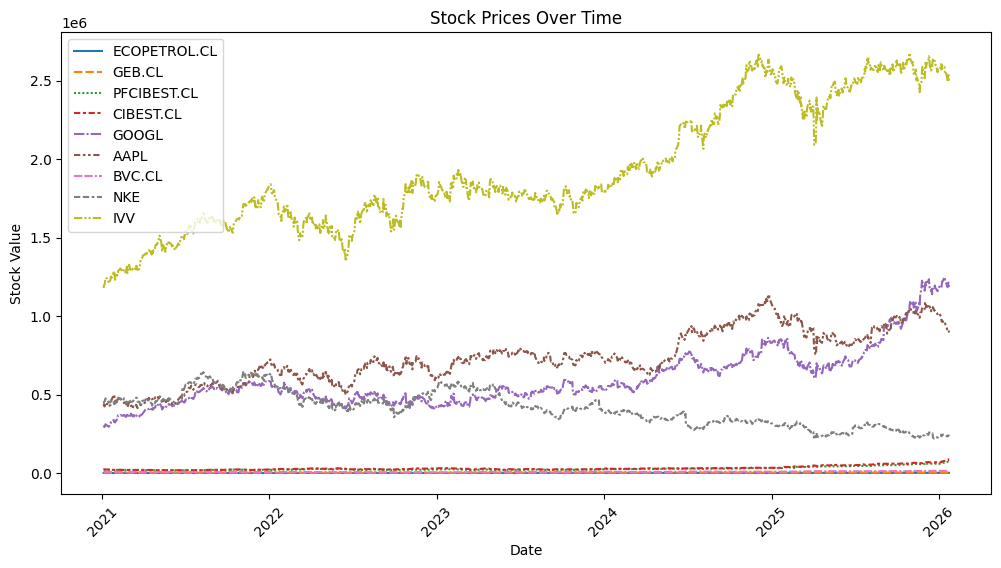

In [9]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_prices)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Stock Prices Over Time')



Text(0.5, 1.0, 'Stock Returns Over Time')

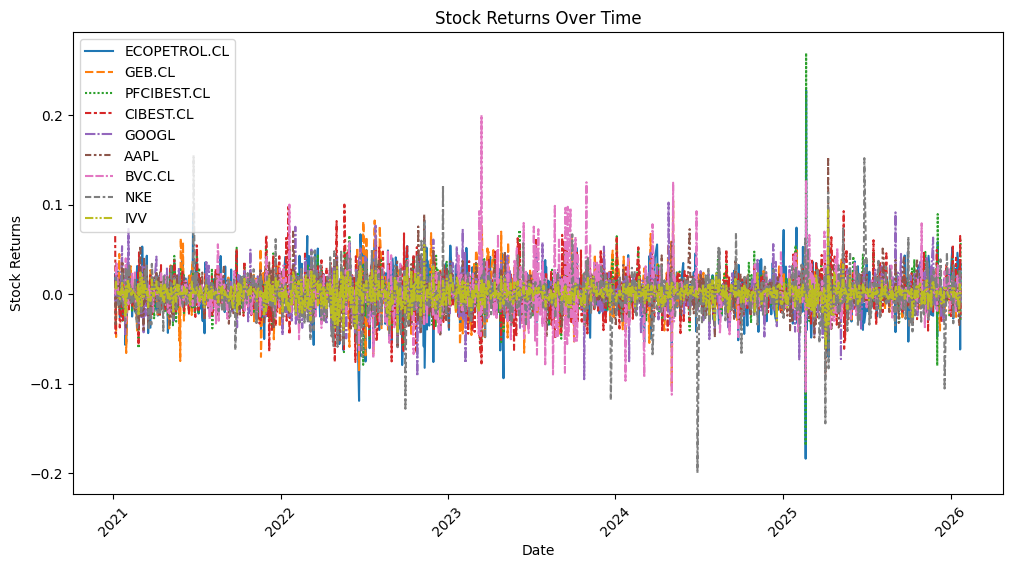

In [10]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_returns)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')

In [11]:
expected_stock_returns = []
individual_stock_risk = []

for x, y in stock_returns.items():
    expected_stock_returns.append(y.mean())

    individual_stock_risk.append(y.std())

In [12]:
print(f"Mean return (percent)")

for name, value in zip(portfolio, expected_stock_returns):
    print(f"\t{name}: \t{value}%")

Mean return (percent)
	ECOPETROL.CL: 	0.0007673983822001681%
	GEB.CL: 	0.0006217253579867619%
	PFCIBEST.CL: 	0.0012784070493822956%
	CIBEST.CL: 	0.0014026494197572458%
	GOOGL: 	0.0010967954255757762%
	AAPL: 	0.0005068254815194664%
	BVC.CL: 	0.0008269764744859875%
	NKE: 	-0.0003592025103749136%
	IVV: 	0.0004884334878784392%


In [13]:
print(f"Risk (Std. Dev)")

for name, value in zip(portfolio, individual_stock_risk):
    print(f"\t{name}: \t{value}")

Risk (Std. Dev)
	ECOPETROL.CL: 	0.023318843341161643
	GEB.CL: 	0.01912403139502936
	PFCIBEST.CL: 	0.019935583205310806
	CIBEST.CL: 	0.021634041427082668
	GOOGL: 	0.019771480107199847
	AAPL: 	0.017708495663474946
	BVC.CL: 	0.02154604258657167
	NKE: 	0.02213206665775128
	IVV: 	0.01081013842960972


In [14]:
expected_stock_returns = np.array(pd.DataFrame(expected_stock_returns))
individual_stock_risk = np.array(pd.DataFrame(individual_stock_risk))

stock_returns_cov_matrix = np.array(stock_returns.cov())

In [15]:
stock_returns_cov_matrix

array([[ 5.43768455e-04,  1.11315911e-04,  2.28505210e-04,
         1.10646946e-04,  5.17875860e-05,  6.51318366e-05,
         7.94134246e-05,  8.35103242e-05,  5.77237494e-05],
       [ 1.11315911e-04,  3.65728577e-04,  7.68721573e-05,
         5.35670421e-05,  2.97005964e-05,  1.96414482e-05,
         6.85054925e-05,  3.87881750e-05,  2.98031463e-05],
       [ 2.28505210e-04,  7.68721573e-05,  3.97427478e-04,
         2.23820160e-04,  5.05218399e-05,  5.78917073e-05,
         8.12279048e-05,  7.14226262e-05,  5.14893482e-05],
       [ 1.10646946e-04,  5.35670421e-05,  2.23820160e-04,
         4.68031748e-04,  3.20834297e-05,  2.47688433e-05,
        -1.22813035e-05,  4.09708491e-05,  3.20582106e-05],
       [ 5.17875860e-05,  2.97005964e-05,  5.05218399e-05,
         3.20834297e-05,  3.90911426e-04,  2.05850912e-04,
         3.17303089e-05,  1.59679231e-04,  1.47888807e-04],
       [ 6.51318366e-05,  1.96414482e-05,  5.78917073e-05,
         2.47688433e-05,  2.05850912e-04,  3.135908

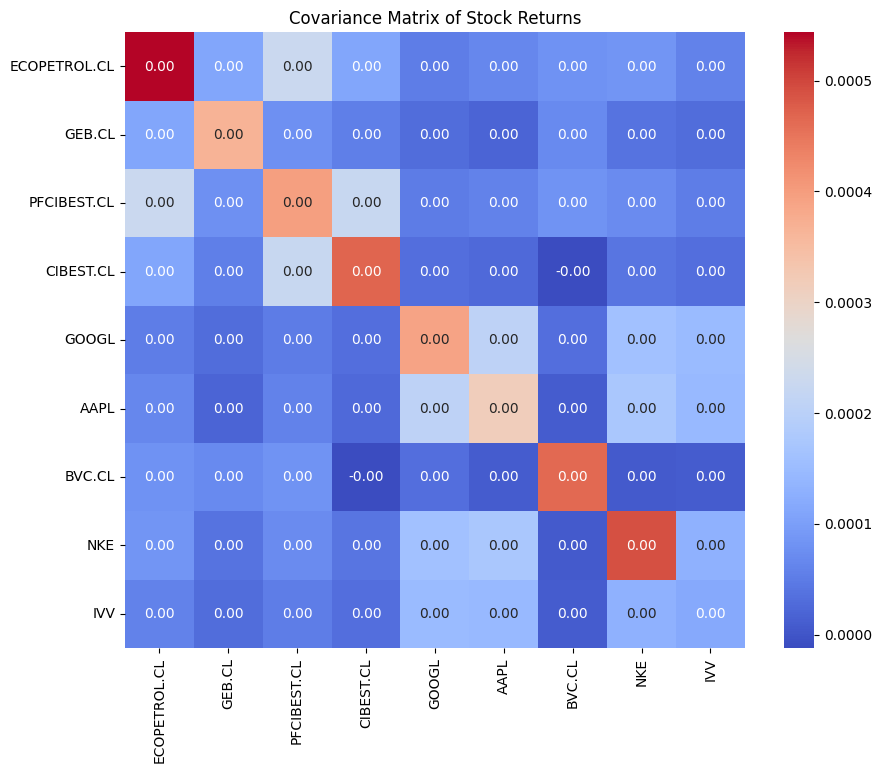

In [16]:
cov_matrix_df = stock_returns.cov()

plt.figure(figsize=(10,8))

sns.heatmap(cov_matrix_df, annot=True, fmt=".2f", cmap='coolwarm')

plt.title('Covariance Matrix of Stock Returns')

plt.show()

In [17]:
cov_matrix_df

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
ECOPETROL.CL,0.000544,0.000111,0.000229,0.000111,0.000052,0.000065,0.000079,0.000084,0.000058
GEB.CL,0.000111,0.000366,0.000077,0.000054,0.000030,0.000020,0.000069,0.000039,0.000030
PFCIBEST.CL,0.000229,0.000077,0.000397,0.000224,0.000051,0.000058,0.000081,0.000071,0.000051
CIBEST.CL,0.000111,0.000054,0.000224,0.000468,0.000032,0.000025,-0.000012,0.000041,0.000032
GOOGL,0.000052,0.000030,0.000051,0.000032,0.000391,0.000206,0.000032,0.000160,0.000148
AAPL,0.000065,0.000020,0.000058,0.000025,0.000206,0.000314,0.000008,0.000174,0.000146
BVC.CL,0.000079,0.000069,0.000081,-0.000012,0.000032,0.000008,0.000464,0.000007,0.000008
NKE,0.000084,0.000039,0.000071,0.000041,0.000160,0.000174,0.000007,0.000490,0.000130
IVV,0.000058,0.000030,0.000051,0.000032,0.000148,0.000146,0.000008,0.000130,0.000117


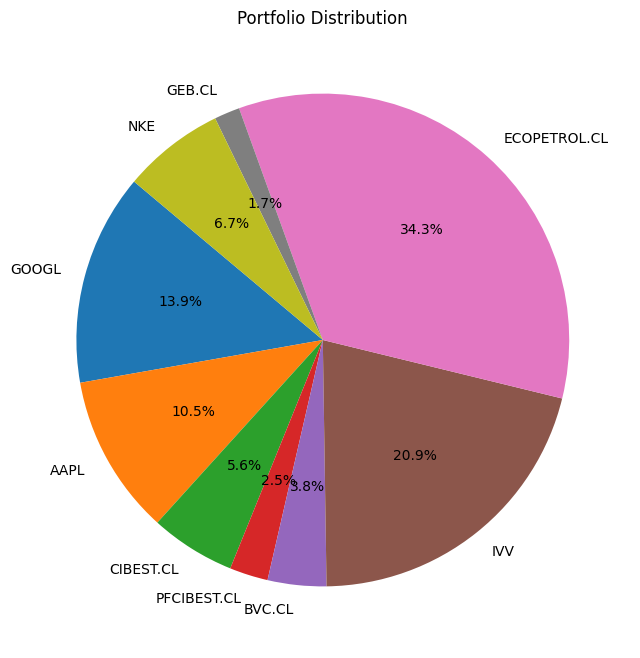

In [18]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

#Pie plot of portfolio distribution
plt.figure(figsize=(8,8))
plt.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Distribution')
plt.show()

In [20]:
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0,1))
ratios = ef.min_volatility()
cleaned_ratios = pd.Series(ratios)
cleaned_ratios.index = portfolio

optimal_portfolio = np.expand_dims(cleaned_ratios, axis=0)

# Rendimiento esperado
opt_portfolio_expected_return = np.matmul(optimal_portfolio, expected_stock_returns)

# Varianza del portafolio
opt_portfolio_var = np.matmul(optimal_portfolio, \
                              np.matmul(stock_returns_cov_matrix, optimal_portfolio.transpose()))

# Riesgo del portafolio
opt_portfolio_risk = math.sqrt(opt_portfolio_var)

# Ver datos obtenidos y Portafolio Óptimo de Markowitz:
print('PORTAFOLIO ÓPTIMO DE MARKOWITZ:')
print(f'Rendimiento esperado: {opt_portfolio_expected_return*100}')
print(f'Varianza del portafolio: {opt_portfolio_var*100}')
print(f'Riesgo del portafolio: {opt_portfolio_risk*100}')

print('\n\nDel 100% de tu capital, el modelo sugiere\
invertir las siguientes proporciones en cada activo:')
display(cleaned_ratios*100)
     


PORTAFOLIO ÓPTIMO DE MARKOWITZ:
Rendimiento esperado: [[0.06634499]]
Varianza del portafolio: [[0.00799033]]
Riesgo del portafolio: 0.8938863854003218


Del 100% de tu capital, el modelo sugiereinvertir las siguientes proporciones en cada activo:


C:\Users\jaayg\AppData\Local\Temp\ipykernel_11236\1680248768.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_portfolio_risk = math.sqrt(opt_portfolio_var)


ECOPETROL.CL     1.317784
GEB.CL          12.103881
PFCIBEST.CL      0.000000
CIBEST.CL       11.612843
GOOGL            0.000000
AAPL             0.000000
BVC.CL          14.485683
NKE              0.000000
IVV             60.479808
dtype: float64

## Portfolio simulation

In [2]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [8]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

In [3]:
def calcular_pesos_minima_volatilidad(returns):
    """
    Calcula los pesos óptimos usando mínima volatilidad
    """
    expected_returns = returns.mean()
    cov_matrix = returns.cov()
    
    ef = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0,1))
    pesos = ef.min_volatility()
    
    return pd.Series(pesos)

In [4]:
def descargar_precios(portfolio, start_date, end_date, stocks_en_usd):
    """
    Descarga precios y convierte USD a COP
    """
    stock_prices = pd.DataFrame()
    
    # Descargar precios de acciones
    for ticker in portfolio:
        stock = yf.Ticker(ticker)
        close_price = stock.history(start=start_date, end=end_date)['Close']
        stock_prices = pd.concat([stock_prices, close_price], axis=1)
    
    stock_prices.columns = portfolio
    
    # Descargar tipo de cambio USD/COP
    usd_cop = yf.Ticker("COP=X").history(start=start_date, end=end_date)['Close']
    usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')
    
    # Convertir acciones en USD a COP
    for ticker in stocks_en_usd:
        if ticker in stock_prices.columns:
            stock_prices[ticker] = stock_prices[ticker] * usd_cop
    
    stock_prices = stock_prices.dropna()
    
    return stock_prices

In [5]:
def backtest_rebalanceo(portfolio, stocks_en_usd, fecha_inicio_entrenamiento, 
                        fecha_inicio_backtest, fecha_fin_backtest, 
                        meses_rebalanceo, inversion_inicial=10000000):
    """
    Realiza backtesting con rebalanceo periódico
    
    Parámetros:
    - meses_rebalanceo: 3 (trimestral), 6 (semestral), 12 (anual)
    - inversion_inicial: capital inicial en COP
    """
    
    # Descargar datos de entrenamiento
    precios_entrenamiento = descargar_precios(
        portfolio, 
        fecha_inicio_entrenamiento, 
        fecha_inicio_backtest,
        stocks_en_usd
    )
    
    # Descargar datos de backtest
    precios_backtest = descargar_precios(
        portfolio,
        fecha_inicio_backtest,
        fecha_fin_backtest,
        stocks_en_usd
    )
    
    # Calcular retornos para entrenamiento inicial
    retornos_entrenamiento = precios_entrenamiento.pct_change().dropna()
    
    # Calcular pesos iniciales
    pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento)
    
    # Inicializar portafolio
    valor_portafolio = [inversion_inicial]
    fechas_rebalanceo = [precios_backtest.index[0]]
    historial_pesos = [pesos_actuales.to_dict()]
    
    # Variables para tracking
    ultima_fecha_rebalanceo = precios_backtest.index[0]
    precio_inicial = precios_backtest.iloc[0]
    acciones = (pesos_actuales * inversion_inicial) / precio_inicial
    
    # Iterar sobre cada día del período de backtest
    for i in range(1, len(precios_backtest)):
        fecha_actual = precios_backtest.index[i]
        precios_actual = precios_backtest.iloc[i]
        
        # Calcular valor actual del portafolio
        valor_actual = (acciones * precios_actual).sum()
        valor_portafolio.append(valor_actual)
        
        # Verificar si toca rebalancear
        meses_transcurridos = (fecha_actual.year - ultima_fecha_rebalanceo.year) * 12 + \
                              (fecha_actual.month - ultima_fecha_rebalanceo.month)
        
        if meses_transcurridos >= meses_rebalanceo:
            # Actualizar datos de entrenamiento hasta la fecha actual
            precios_entrenamiento_actual = descargar_precios(
                portfolio,
                fecha_inicio_entrenamiento,
                fecha_actual.strftime('%Y-%m-%d'),
                stocks_en_usd
            )
            
            retornos_entrenamiento_actual = precios_entrenamiento_actual.pct_change().dropna()
            
            # Recalcular pesos óptimos
            pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento_actual)
            
            # Rebalancear: vender todo y comprar según nuevos pesos
            acciones = (pesos_actuales * valor_actual) / precios_actual
            
            # Guardar información del rebalanceo
            ultima_fecha_rebalanceo = fecha_actual
            fechas_rebalanceo.append(fecha_actual)
            historial_pesos.append(pesos_actuales.to_dict())

    resultados = pd.DataFrame({
        'Valor_Portafolio': valor_portafolio
    }, index=precios_backtest.index)
    
    resultados['Retorno_Acumulado'] = (resultados['Valor_Portafolio'] / inversion_inicial - 1) * 100
    resultados['Retorno_Diario'] = resultados['Valor_Portafolio'].pct_change()
    
    # Métricas de desempeño
    retorno_total = (valor_portafolio[-1] / inversion_inicial - 1) * 100
    retorno_anualizado = ((valor_portafolio[-1] / inversion_inicial) ** 
                          (252 / len(precios_backtest)) - 1) * 100
    volatilidad_anualizada = resultados['Retorno_Diario'].std() * np.sqrt(252) * 100
    sharpe_ratio = retorno_anualizado / volatilidad_anualizada if volatilidad_anualizada > 0 else 0
    
    # Drawdown
    cummax = resultados['Valor_Portafolio'].cummax()
    drawdown = (resultados['Valor_Portafolio'] - cummax) / cummax * 100
    max_drawdown = drawdown.min()
    
    metricas = {
        'Retorno Total (%)': retorno_total,
        'Retorno Anualizado (%)': retorno_anualizado,
        'Volatilidad Anualizada (%)': volatilidad_anualizada,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Num Rebalanceos': len(fechas_rebalanceo) - 1
    }
    
    return resultados, metricas, fechas_rebalanceo, historial_pesos

Ejecutando backtests...

1. REBALANCEO TRIMESTRAL (cada 3 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 135.51
Retorno Anualizado (%): 34.74
Volatilidad Anualizada (%): 17.07
Sharpe Ratio: 2.04
Max Drawdown (%): -11.25
Num Rebalanceos: 12.00

2. REBALANCEO SEMESTRAL (cada 6 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 138.17
Retorno Anualizado (%): 35.26
Volatilidad Anualizada (%): 17.25
Sharpe Ratio: 2.04
Max Drawdown (%): -11.25
Num Rebalanceos: 6.00

3. REBALANCEO ANUAL (cada 12 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 146.62
Retorno Anualizado (%): 36.92
Volatilidad Anualizada (%): 18.69
Sharpe Ratio: 1.97
Max Drawdown (%): -14.01
Num Rebalanceos: 3.00

4. BUY AND HOLD (sin rebalanceo)
--------------------------------------------------------------------------------
Retorno Total (%): 141.05
Retor

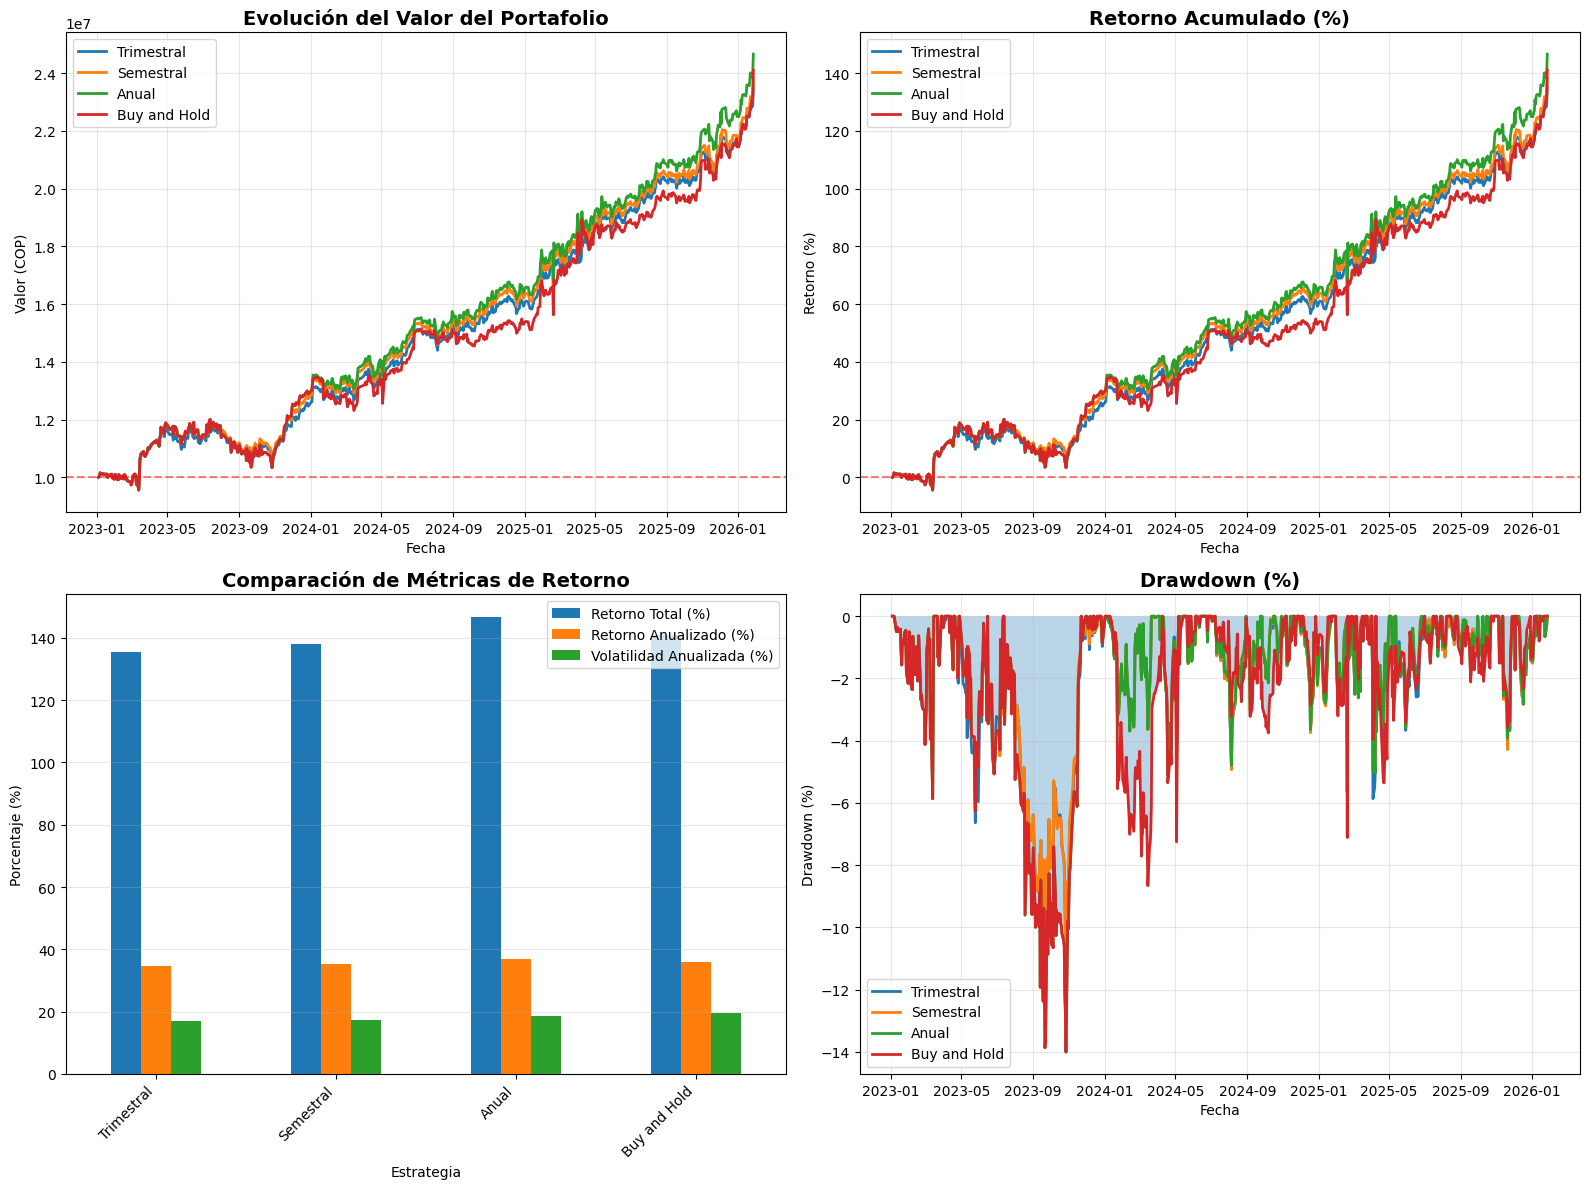


TABLA RESUMEN DE MÉTRICAS
                            Trimestral  Semestral   Anual  Buy and Hold
Retorno Total (%)               135.51     138.17  146.62        141.05
Retorno Anualizado (%)           34.74      35.26   36.92         35.83
Volatilidad Anualizada (%)       17.07      17.25   18.69         19.47
Sharpe Ratio                      2.04       2.04    1.97          1.84
Max Drawdown (%)                -11.25     -11.25  -14.01        -14.01
Num Rebalanceos                  12.00       6.00    3.00          0.00


ModuleNotFoundError: No module named 'openpyxl'

In [9]:


# EJECUTAR BACKTESTS CON DIFERENTES FRECUENCIAS
print("Ejecutando backtests...")
print("=" * 80)

# Parámetros
fecha_inicio_entrenamiento = '2021-01-01'
fecha_inicio_backtest = '2023-01-01'
fecha_fin_backtest = datetime.now().strftime('%Y-%m-%d')
inversion_inicial = 10_000_000  # 10 millones COP

# Diccionario para almacenar resultados
resultados_todos = {}

# 1. Rebalanceo trimestral (cada 3 meses)
print("\n1. REBALANCEO TRIMESTRAL (cada 3 meses)")
print("-" * 80)
resultados_3m, metricas_3m, fechas_reb_3m, pesos_3m = backtest_rebalanceo(
    portfolio, stocks_en_usd, 
    fecha_inicio_entrenamiento, 
    fecha_inicio_backtest, 
    fecha_fin_backtest,
    meses_rebalanceo=3,
    inversion_inicial=inversion_inicial
)
resultados_todos['Trimestral'] = resultados_3m
for metrica, valor in metricas_3m.items():
    print(f"{metrica}: {valor:.2f}")

# 2. Rebalanceo semestral (cada 6 meses)
print("\n2. REBALANCEO SEMESTRAL (cada 6 meses)")
print("-" * 80)
resultados_6m, metricas_6m, fechas_reb_6m, pesos_6m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=6,
    inversion_inicial=inversion_inicial
)
resultados_todos['Semestral'] = resultados_6m
for metrica, valor in metricas_6m.items():
    print(f"{metrica}: {valor:.2f}")

# 3. Rebalanceo anual (cada 12 meses)
print("\n3. REBALANCEO ANUAL (cada 12 meses)")
print("-" * 80)
resultados_12m, metricas_12m, fechas_reb_12m, pesos_12m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=12,
    inversion_inicial=inversion_inicial
)
resultados_todos['Anual'] = resultados_12m
for metrica, valor in metricas_12m.items():
    print(f"{metrica}: {valor:.2f}")

# 4. Buy and Hold (sin rebalanceo)
print("\n4. BUY AND HOLD (sin rebalanceo)")
print("-" * 80)
resultados_bh, metricas_bh, fechas_reb_bh, pesos_bh = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=999,  # Número grande para evitar rebalanceos
    inversion_inicial=inversion_inicial
)
resultados_todos['Buy and Hold'] = resultados_bh
for metrica, valor in metricas_bh.items():
    print(f"{metrica}: {valor:.2f}")

# VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución del valor del portafolio
ax1 = axes[0, 0]
for nombre, resultado in resultados_todos.items():
    ax1.plot(resultado.index, resultado['Valor_Portafolio'], label=nombre, linewidth=2)
ax1.set_title('Evolución del Valor del Portafolio', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Valor (COP)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=inversion_inicial, color='red', linestyle='--', alpha=0.5, label='Inversión Inicial')

# 2. Retorno acumulado
ax2 = axes[0, 1]
for nombre, resultado in resultados_todos.items():
    ax2.plot(resultado.index, resultado['Retorno_Acumulado'], label=nombre, linewidth=2)
ax2.set_title('Retorno Acumulado (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Retorno (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Comparación de métricas
ax3 = axes[1, 0]
metricas_comparacion = pd.DataFrame({
    'Trimestral': metricas_3m,
    'Semestral': metricas_6m,
    'Anual': metricas_12m,
    'Buy and Hold': metricas_bh
})
metricas_comparacion.loc[['Retorno Total (%)', 'Retorno Anualizado (%)', 
                           'Volatilidad Anualizada (%)']].T.plot(kind='bar', ax=ax3)
ax3.set_title('Comparación de Métricas de Retorno', fontsize=14, fontweight='bold')
ax3.set_xlabel('Estrategia')
ax3.set_ylabel('Porcentaje (%)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Drawdown
ax4 = axes[1, 1]
for nombre, resultado in resultados_todos.items():
    cummax = resultado['Valor_Portafolio'].cummax()
    drawdown = (resultado['Valor_Portafolio'] - cummax) / cummax * 100
    ax4.plot(resultado.index, drawdown, label=nombre, linewidth=2)
ax4.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Fecha')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.fill_between(resultado.index, drawdown, 0, alpha=0.3)

plt.tight_layout()
plt.savefig('backtest_rebalanceo_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# TABLA RESUMEN
print("\n" + "=" * 80)
print("TABLA RESUMEN DE MÉTRICAS")
print("=" * 80)
print(metricas_comparacion.round(2))

# Exportar a Excel
with pd.ExcelWriter('backtest_resultados.xlsx') as writer:
    metricas_comparacion.to_excel(writer, sheet_name='Métricas')
    resultados_3m.to_excel(writer, sheet_name='Trimestral')
    resultados_6m.to_excel(writer, sheet_name='Semestral')
    resultados_12m.to_excel(writer, sheet_name='Anual')
    resultados_bh.to_excel(writer, sheet_name='Buy and Hold')

print("\nResultados exportados a 'backtest_resultados.xlsx'")